In [1]:
import os

os.environ["LANGCHAIN_TRACING_V2"] = "false"

In [2]:

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_openai import ChatOpenAI


In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from typing import Annotated, List
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage
from pydantic import BaseModel, ConfigDict

class State(BaseModel):
    messages: Annotated[List[BaseMessage], add_messages]

    model_config = ConfigDict(arbitrary_types_allowed=True)


In [5]:
from langchain.tools import tool
import os, requests

ALPHAVANTAGE_API_KEY = os.getenv("ALPHAVANTAGE_API_KEY")

@tool
def get_stock_price(symbol: str) -> float:
    """Get the latest stock price for a symbol."""
    if not ALPHAVANTAGE_API_KEY:
        raise ValueError("Alpha Vantage API key not set")

    url = "https://www.alphavantage.co/query"
    params = {
        "function": "GLOBAL_QUOTE",
        "symbol": symbol,
        "apikey": ALPHAVANTAGE_API_KEY,
    }

    response = requests.get(url, params=params, timeout=10)
    response.raise_for_status()
    data = response.json()

    quote = data.get("Global Quote", {})
    price = quote.get("05. price")

    if not price:
        raise ValueError(f"No price found for {symbol}")

    return float(price)


In [6]:
def chatbot(state: State):
    response = llm_with_tools.invoke(state.messages)
    return {"messages": [response]}


In [7]:
tools = [get_stock_price]

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
)

llm_with_tools = llm.bind_tools(tools)


In [8]:
builder = StateGraph(State)

builder.add_node("chatbot", chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
builder.add_edge("tools", "chatbot")

graph = builder.compile()


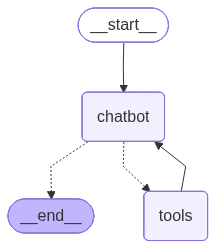

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
state = graph.invoke({
    "messages": [
        {"role": "user", "content": "What is the price of AAPL stock right now?"}
    ]
})

print(state["messages"][-1].content)


The current price of AAPL stock is $259.48.


In [11]:
from langsmith import traceable

@traceable(name="agent_tools_run")
def run_agent(user_input: str):
    return graph.invoke({
        "messages": [
            {"role": "user", "content": user_input}
        ]
    })


In [16]:
state = graph.invoke({"messages": [{"role": "user", "content": "What is the price of MSFT stock right now?"}]})
print(state["messages"][-1].content)

The current price of MSFT stock is $430.29.


In [13]:
from pprint import pprint

state = graph.invoke({
    "messages": [{"role": "user", "content": "What is the price of AAPL stock right now?"}]
})

pprint(state)

{'messages': [HumanMessage(content='What is the price of AAPL stock right now?', additional_kwargs={}, response_metadata={}, id='73578205-9802-4813-bb7a-742aa116835a'),
              AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 58, 'total_tokens': 74, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_1590f93f9d', 'id': 'chatcmpl-D4mKVynXbIMngRGWbg0vzClmC5XYy', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c1e18-bcd6-7ac0-ab6e-97f3be3e54da-0', tool_calls=[{'name': 'get_stock_price', 'args': {'symbol': 'AAPL'}, 'id': 'call_dQEf4JVO5Bf6D2Y5vSaBLnxt', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadat

In [14]:
state = graph.invoke({"messages": [{"role": "user", "content": "Who invented theory of relativity? print person name only"}]})
print(state["messages"][-1].content)

Albert Einstein


In [15]:


state = graph.invoke({
    "messages": [{"role": "user", "content": "Who invented theory of relativity? print person name only?"}]
})

pprint(state)

{'messages': [HumanMessage(content='Who invented theory of relativity? print person name only?', additional_kwargs={}, response_metadata={}, id='f1f6b66a-7549-41f6-b780-b8a50ee501fd'),
              AIMessage(content='Albert Einstein', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 3, 'prompt_tokens': 59, 'total_tokens': 62, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_1590f93f9d', 'id': 'chatcmpl-D4mKZ2S01w7n4Xc1elfoDZIquEqk2', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019c1e18-ca13-7203-94e9-bd234e9d2a77-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 59, 'output_tokens': 3, 'total_tokens': 62, 'input_token_details': {'aud